In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

from tqdm.notebook import tqdm

import pandas as pd


# Loading File

In [2]:
# from data_files/CombinedFunctions_from_Fortran/CombinedTypes.h
particle_types = {
    1: "gamma",
    2: "positron",
    3: "electron",
    4: "neutrino",
    5: "mu+",
    6: "mu-",
    7: "pi0",
    8: "pi+",
    9: "pi-",
    10: "K0L",
    11: "K+",
    12: "K-",
    13: "neutron",
    14: "proton",
    15: "anti-proton",
    16: "K0S",
    17: "eta",
    18: "lambda",
    19: "sigma+",
    20: "sigma0",
    21: "sigma-",
    22: "xi0",
    23: "xi-",
    24: "omega-",
    25: "anti-neutron",
    26: "anti-lambda",
    27: "anti-sigma-",
    28: "anti-sigma0",
    29: "anti-sigma+",
    30: "anti-xi0",
    31: "anti-xi+",
    32: "anti-omega+",
    45: "deuteron",
    46: "triton",
    47: "alpha",
    48: "geantino",
    49: "He3",
    50: "Cerenkov"
}

# from data_files/SomeMiniBooNEDetails_on_files_v2.pdf
nu_types = {
    1: "numu",
    2: "numubar",
    3: "nue",
    4: "nuebar"
}


In [3]:
max_file_to_load = 10

shower_threshold = 20
track_threshold = 10

two_HE_shower_0_HE_track_df = pd.DataFrame()

for file_i in tqdm(range(1, max_file_to_load + 1)):

    f = uproot.open(f"data_files/output_osc_mc_detail_{file_i}.root")

    df = f["MiniBooNE_CCQE"].arrays(["EventNumber", "Weight", "PassOsc", "RecoEnuQE", "Energy", "CosTheta", "TrueEnergy", "NuType", "NFSP", "FSPType", "MomX", "MomY", "MomZ", "MomT"], library="pd")

    df["nu_type"] = df["NuType"].apply(lambda x: nu_types[x])
    df.drop(columns=["NuType"], inplace=True)

    particle_codes = df["FSPType"].to_numpy()
    particle_MomXs = df["MomX"].to_numpy()
    particle_MomYs = df["MomY"].to_numpy()
    particle_MomZs = df["MomZ"].to_numpy()
    particle_MomTs = df["MomT"].to_numpy()

    num_true_HE_showers = []
    num_true_HE_tracks = []
    for i in range(len(particle_codes)):
        curr_num_showers = 0
        curr_num_HE_showers = 0
        curr_num_HE_tracks = 0
        curr_particle_codes = particle_codes[i]
        curr_MomTs = particle_MomTs[i]
        for j in range(len(curr_particle_codes)):
            curr_particle_type = particle_types[curr_particle_codes[j]]
            curr_particle_energy = curr_MomTs[j] * 1000

            if (curr_particle_type == "gamma" or curr_particle_type == "electron" or curr_particle_type == "positron") and curr_particle_energy > shower_threshold:
                curr_num_HE_showers += 1

            if (curr_particle_type == "proton" or curr_particle_type == "mu+" or curr_particle_type == "mu-" or curr_particle_type == "pi+" or curr_particle_type == "pi-") and curr_particle_energy > track_threshold:
                curr_num_HE_tracks += 1

        num_true_HE_showers.append(curr_num_HE_showers)
        num_true_HE_tracks.append(curr_num_HE_tracks)

    df["num_true_HE_showers"] = num_true_HE_showers
    df["num_true_HE_tracks"] = num_true_HE_tracks

    df = df.query("num_true_HE_showers == 2 and num_true_HE_tracks == 0")

    two_HE_shower_0_HE_track_df = pd.concat([two_HE_shower_0_HE_track_df, df])

two_HE_shower_0_HE_track_df


  0%|          | 0/10 [00:00<?, ?it/s]

,EventNumber,Weight,PassOsc,RecoEnuQE,Energy,CosTheta,TrueEnergy,NFSP,FSPType,MomX,MomY,MomZ,MomT,nu_type,num_true_HE_showers,num_true_HE_tracks
61,83,1.028384,False,0.008496,9.246018,0.645353,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[0.9859887361526489, -0.3957420587539673, -0.2...","[-0.019482064992189407, -0.36899009346961975, ...","[0.1656704545021057, 0.8409724235534668, 0.955...","[0.35693037509918213, 0.37499508261680603, 0.9...",numu,2,0
104,152,1.238010,False,0.234082,202.115295,0.351300,-9999.0,4,"[4, 7, 1, 1]","[0.2000061720609665, -0.564384937286377, -0.73...","[0.1383332759141922, 0.2767889201641083, 0.626...","[0.9699801802635193, 0.777725875377655, 0.2717...","[0.9824506640434265, 0.1503450721502304, 0.110...",numu,2,0
122,181,1.056676,False,0.081332,80.902153,0.828191,-9999.0,10,"[4, 7, 13, 1, 45, 1, 45, 1, 1, 1]","[-0.672749400138855, -0.8169224262237549, 0.33...","[0.5677669048309326, -0.5554943084716797, -0.4...","[0.47439321875572205, 0.1551249921321869, 0.84...","[0.5447632670402527, 0.09576935321092606, 0.89...",numu,2,0
145,220,1.058410,False,0.119235,114.573265,0.627293,-9999.0,4,"[4, 7, 1, 1]","[0.07208839058876038, -0.30924978852272034, -0...","[-0.21400323510169983, -0.22997568547725677, -...","[0.9741693139076233, 0.9227544069290161, 0.870...","[0.9067493677139282, 0.2647542655467987, 0.262...",numu,2,0
165,251,1.156679,False,1.105776,467.479767,-0.160315,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[0.914799690246582, 0.4782121777534485, -0.102...","[-0.4037371873855591, 0.878177285194397, -0.14...","[-0.011736511252820492, -0.010845515877008438,...","[0.18399429321289062, 0.1280408799648285, 0.74...",numu,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416771,4512,0.958246,False,0.784065,473.724091,0.213838,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[-0.0036263694055378437, -0.24570761620998383,...","[-0.1256856620311737, 0.9551464319229126, -0.4...","[0.9920635223388672, 0.1652970016002655, 0.877...","[0.9006029367446899, 0.42732682824134827, 0.91...",numu,2,0
416907,4731,1.306772,False,0.253484,221.657028,0.455978,-9999.0,12,"[4, 7, 13, 1, 45, 1, 45, 1, 45, 1, 1, 1]","[-0.4080476462841034, 0.7688096761703491, 0.31...","[0.0609237365424633, 0.582097053527832, -0.240...","[0.9109255075454712, 0.26475420594215393, 0.91...","[0.8975388407707214, 0.20591358840465546, 0.76...",numu,2,0
416952,4810,1.108857,False,0.098397,94.791588,0.560505,-9999.0,5,"[4, 7, 13, 1, 1]","[0.9018092155456543, -0.800337553024292, -0.05...","[0.05555407330393791, -0.26291167736053467, 0....","[0.428548663854599, 0.538829505443573, 0.99480...","[0.19919010996818542, 0.34294256567955017, 0.7...",numu,2,0
416963,4827,1.679400,False,0.271468,214.422501,0.068823,-9999.0,4,"[4, 13, 1, 1]","[-0.35947534441947937, 0.23785465955734253, -0...","[0.4992363750934601, -0.5580182671546936, -0.8...","[0.7883784174919128, 0.7950099110603333, 0.105...","[0.9072497487068176, 0.8654321432113647, 0.163...",numu,2,0


# True Quantities for two showers

In [4]:
particle_codes = two_HE_shower_0_HE_track_df["FSPType"].to_numpy()
particle_MomXs = two_HE_shower_0_HE_track_df["MomX"].to_numpy()
particle_MomYs = two_HE_shower_0_HE_track_df["MomY"].to_numpy()
particle_MomZs = two_HE_shower_0_HE_track_df["MomZ"].to_numpy()
particle_MomTs = two_HE_shower_0_HE_track_df["MomT"].to_numpy()

leading_energies = []
subleading_energies = []
opening_angles = []
total_momentum_beam_angles = []

for i in tqdm(range(len(particle_codes))):

    curr_leading_energy = -np.inf
    curr_subleading_energy = -np.inf
    curr_leading_momentum = np.array([np.nan, np.nan, np.nan])
    curr_subleading_momentum = np.array([np.nan, np.nan, np.nan])

    curr_particle_codes = particle_codes[i]
    curr_MomXs = particle_MomXs[i]
    curr_MomYs = particle_MomYs[i]
    curr_MomZs = particle_MomZs[i]
    curr_MomTs = particle_MomTs[i]

    for j in range(len(curr_particle_codes)):
        curr_particle_type = particle_types[curr_particle_codes[j]]
        curr_particle_energy = curr_MomTs[j] * 1000
        curr_particle_momentum = np.array([curr_MomXs[j], curr_MomYs[j], curr_MomZs[j]])
        if curr_particle_type == "gamma" or curr_particle_type == "electron" or curr_particle_type == "positron" and curr_particle_energy > 20:
            if curr_particle_energy > curr_leading_energy: # new highest energy shower
                curr_subleading_energy = curr_leading_energy
                curr_subleading_momentum = curr_leading_momentum
                curr_leading_energy = curr_particle_energy
                curr_leading_momentum = curr_particle_momentum
            elif curr_particle_energy > curr_subleading_energy: # new subleading shower
                curr_subleading_energy = curr_particle_energy
                curr_subleading_momentum = curr_particle_momentum
        
    curr_total_momentum = curr_leading_momentum + curr_subleading_momentum
    curr_total_momentum_magnitude = np.linalg.norm(curr_total_momentum)
    curr_total_momentum_beam_angle = np.arccos(curr_total_momentum[2] / curr_total_momentum_magnitude) * 180 / np.pi

    curr_opening_angle = np.arccos(np.dot(curr_leading_momentum, curr_subleading_momentum) / (np.linalg.norm(curr_leading_momentum) * np.linalg.norm(curr_subleading_momentum))) * 180 / np.pi

    leading_energies.append(curr_leading_energy)
    subleading_energies.append(curr_subleading_energy)
    opening_angles.append(curr_opening_angle)
    total_momentum_beam_angles.append(curr_total_momentum_beam_angle)

two_HE_shower_0_HE_track_df["leading_energy"] = leading_energies
two_HE_shower_0_HE_track_df["subleading_energy"] = subleading_energies
two_HE_shower_0_HE_track_df["opening_angle"] = opening_angles
two_HE_shower_0_HE_track_df["total_momentum_beam_angle"] = total_momentum_beam_angles

two_HE_shower_0_HE_track_df


  0%|          | 0/191277 [00:00<?, ?it/s]

,EventNumber,Weight,PassOsc,RecoEnuQE,Energy,CosTheta,TrueEnergy,NFSP,FSPType,MomX,MomY,MomZ,MomT,nu_type,num_true_HE_showers,num_true_HE_tracks,leading_energy,subleading_energy,opening_angle,total_momentum_beam_angle
61,83,1.028384,False,0.008496,9.246018,0.645353,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[0.9859887361526489, -0.3957420587539673, -0.2...","[-0.019482064992189407, -0.36899009346961975, ...","[0.1656704545021057, 0.8409724235534668, 0.955...","[0.35693037509918213, 0.37499508261680603, 0.9...",numu,2,0,217.459694,181.087583,39.764741,30.996489
104,152,1.238010,False,0.234082,202.115295,0.351300,-9999.0,4,"[4, 7, 1, 1]","[0.2000061720609665, -0.564384937286377, -0.73...","[0.1383332759141922, 0.2767889201641083, 0.626...","[0.9699801802635193, 0.777725875377655, 0.2717...","[0.9824506640434265, 0.1503450721502304, 0.110...",numu,2,0,110.784724,91.260493,84.318208,34.412661
122,181,1.056676,False,0.081332,80.902153,0.828191,-9999.0,10,"[4, 7, 13, 1, 45, 1, 45, 1, 1, 1]","[-0.672749400138855, -0.8169224262237549, 0.33...","[0.5677669048309326, -0.5554943084716797, -0.4...","[0.47439321875572205, 0.1551249921321869, 0.84...","[0.5447632670402527, 0.09576935321092606, 0.89...",numu,2,0,102.504037,62.996402,114.247644,64.206105
145,220,1.058410,False,0.119235,114.573265,0.627293,-9999.0,4,"[4, 7, 1, 1]","[0.07208839058876038, -0.30924978852272034, -0...","[-0.21400323510169983, -0.22997568547725677, -...","[0.9741693139076233, 0.9227544069290161, 0.870...","[0.9067493677139282, 0.2647542655467987, 0.262...",numu,2,0,262.984246,34.191556,90.748562,20.274758
165,251,1.156679,False,1.105776,467.479767,-0.160315,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[0.914799690246582, 0.4782121777534485, -0.102...","[-0.4037371873855591, 0.878177285194397, -0.14...","[-0.011736511252820492, -0.010845515877008438,...","[0.18399429321289062, 0.1280408799648285, 0.74...",numu,2,0,155.054569,30.991374,153.593274,95.886355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416771,4512,0.958246,False,0.784065,473.724091,0.213838,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[-0.0036263694055378437, -0.24570761620998383,...","[-0.1256856620311737, 0.9551464319229126, -0.4...","[0.9920635223388672, 0.1652970016002655, 0.877...","[0.9006029367446899, 0.42732682824134827, 0.91...",numu,2,0,260.122597,188.014492,35.536890,82.812713
416907,4731,1.306772,False,0.253484,221.657028,0.455978,-9999.0,12,"[4, 7, 13, 1, 45, 1, 45, 1, 45, 1, 1, 1]","[-0.4080476462841034, 0.7688096761703491, 0.31...","[0.0609237365424633, 0.582097053527832, -0.240...","[0.9109255075454712, 0.26475420594215393, 0.91...","[0.8975388407707214, 0.20591358840465546, 0.76...",numu,2,0,199.667722,46.541627,88.868273,90.628253
416952,4810,1.108857,False,0.098397,94.791588,0.560505,-9999.0,5,"[4, 7, 13, 1, 1]","[0.9018092155456543, -0.800337553024292, -0.05...","[0.05555407330393791, -0.26291167736053467, 0....","[0.428548663854599, 0.538829505443573, 0.99480...","[0.19919010996818542, 0.34294256567955017, 0.7...",numu,2,0,346.663684,21.885142,101.576845,36.289651
416963,4827,1.679400,False,0.271468,214.422501,0.068823,-9999.0,4,"[4, 13, 1, 1]","[-0.35947534441947937, 0.23785465955734253, -0...","[0.4992363750934601, -0.5580182671546936, -0.8...","[0.7883784174919128, 0.7950099110603333, 0.105...","[0.9072497487068176, 0.8654321432113647, 0.163...",numu,2,0,163.271025,32.840665,134.337838,71.388624


In [5]:
passing_two_HE_shower_0_HE_track_df = two_HE_shower_0_HE_track_df.query("PassOsc == True")
passing_two_HE_shower_0_HE_track_df

,EventNumber,Weight,PassOsc,RecoEnuQE,Energy,CosTheta,TrueEnergy,NFSP,FSPType,MomX,MomY,MomZ,MomT,nu_type,num_true_HE_showers,num_true_HE_tracks,leading_energy,subleading_energy,opening_angle,total_momentum_beam_angle
14270,2531,1.124880,True,0.298375,183.644623,-0.975182,-9999.0,7,"[4, 7, 13, 1, 1, 1, 1]","[-0.003586800303310156, 0.29294952750205994, 0...","[-0.1321813464164734, 0.02484089881181717, 0.4...","[0.9912190437316895, -0.9558051228523254, 0.80...","[1.0216951370239258, 0.1503000557422638, 0.419...",numu,2,0,168.890774,33.120926,128.936621,110.192349
20933,3117,1.422729,True,0.189715,163.669266,0.190752,-9999.0,16,"[4, 7, 13, 45, 1, 45, 1, 45, 1, 1, 1, 13, 13, ...","[0.9644405841827393, -0.82551509141922, -0.116...","[-0.2554657459259033, 0.558964192867279, 0.146...","[0.06776169687509537, 0.07799886912107468, 0.9...","[0.2609784007072449, 0.1822686344385147, 0.650...",numu,2,0,138.005182,88.799745,75.127125,86.202347
29989,2472,1.137632,True,0.306389,244.803970,0.220383,-9999.0,7,"[4, 13, 7, 1, 1, 45, 1]","[-0.3743347227573395, 0.6337068676948547, -0.5...","[-0.2948390245437622, -0.10316871851682663, 0....","[0.8791719675064087, 0.7666627764701843, 0.433...","[0.5962215065956116, 0.4814160168170929, 0.335...",numu,2,0,207.597986,154.289216,44.307463,61.703369
31512,4901,0.606244,True,1.276216,1166.114990,0.930027,-9999.0,15,"[4, 7, 13, 45, 1, 45, 1, 45, 1, 45, 1, 1, 1, 1...","[-0.02605859935283661, -0.04985184222459793, 0...","[-0.3827979564666748, 0.3324052691459656, 0.65...","[0.9234644770622253, 0.941818118095398, 0.7291...","[2.6975109577178955, 1.1831961870193481, 1.083...",numu,2,0,1085.131288,105.738685,22.984678,24.248397
45066,1550,0.755625,True,2.270351,2136.054443,0.973836,-9999.0,8,"[4, 7, 13, 1, 45, 1, 1, 1]","[-0.2840479016304016, -0.02326793782413006, 0....","[-0.16395892202854156, 0.25602877140045166, -0...","[0.9446874260902405, 0.9663890600204468, 0.534...","[1.2635982036590576, 2.1115503311157227, 0.609...",numu,2,0,1433.873296,681.986749,7.826631,14.147154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380384,1625,1.137920,True,0.181821,159.832733,0.266181,-9999.0,4,"[4, 7, 1, 1]","[0.3090524971485138, -0.4829445779323578, -0.2...","[0.1050788089632988, -0.5646669268608093, -0.2...","[0.9452221989631653, 0.6692649722099304, 0.942...","[0.9628809094429016, 0.2217751145362854, 0.139...",numu,2,0,139.129654,120.490827,62.831427,50.486134
388605,4741,0.838476,True,0.383841,382.949280,0.989322,-9999.0,4,"[4, 7, 1, 1]","[0.16753271222114563, 0.1629125475883484, 0.14...","[-0.09006930887699127, 0.12706097960472107, -0...","[0.9817434549331665, 0.9784247279167175, 0.988...","[0.5719684958457947, 0.5035761594772339, 0.357...",numu,2,0,357.494891,163.856775,32.382402,16.780790
389220,718,0.639102,True,0.547106,517.680420,0.899891,-9999.0,7,"[4, 7, 13, 45, 1, 1, 1]","[-0.7354196310043335, -0.2614152133464813, 0.1...","[0.18352167308330536, 0.35074612498283386, -0....","[-0.65228670835495, 0.8992437124252319, 0.8078...","[0.08701442927122116, 0.44323426485061646, 0.2...",numu,2,0,436.268657,27.061913,76.795118,60.620092
405465,1554,0.941614,True,0.199248,164.813309,-0.004478,-9999.0,5,"[4, 7, 13, 1, 1]","[-0.31914785504341125, 0.9335773587226868, -0....","[0.11655265092849731, 0.09829047322273254, -0....","[0.9405104517936707, 0.34463343024253845, 0.93...","[0.6371172070503235, 0.3154001235961914, 0.273...",numu,2,0,198.679194,144.389108,46.963851,73.770722


# Efficiencies

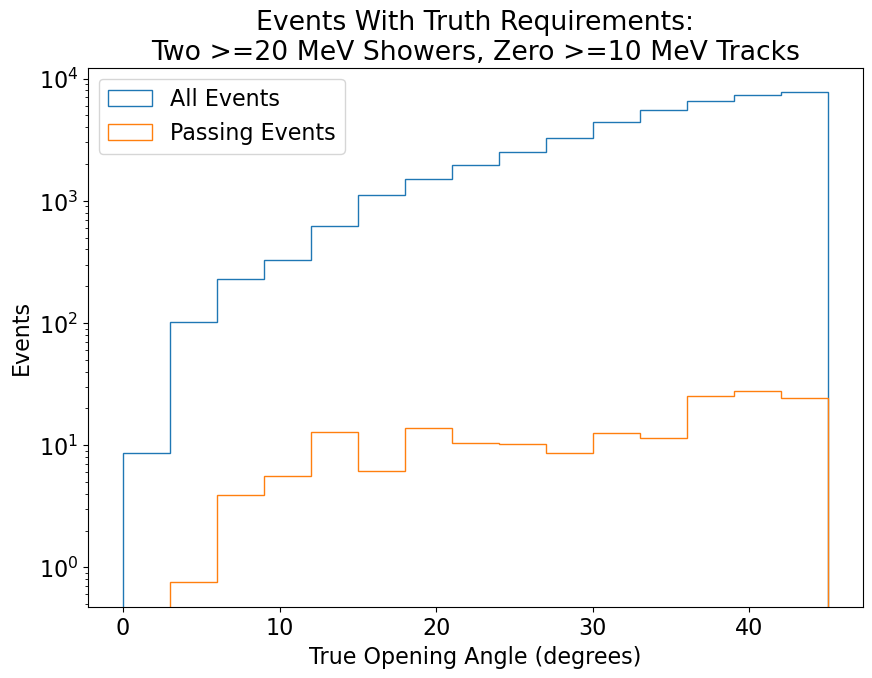

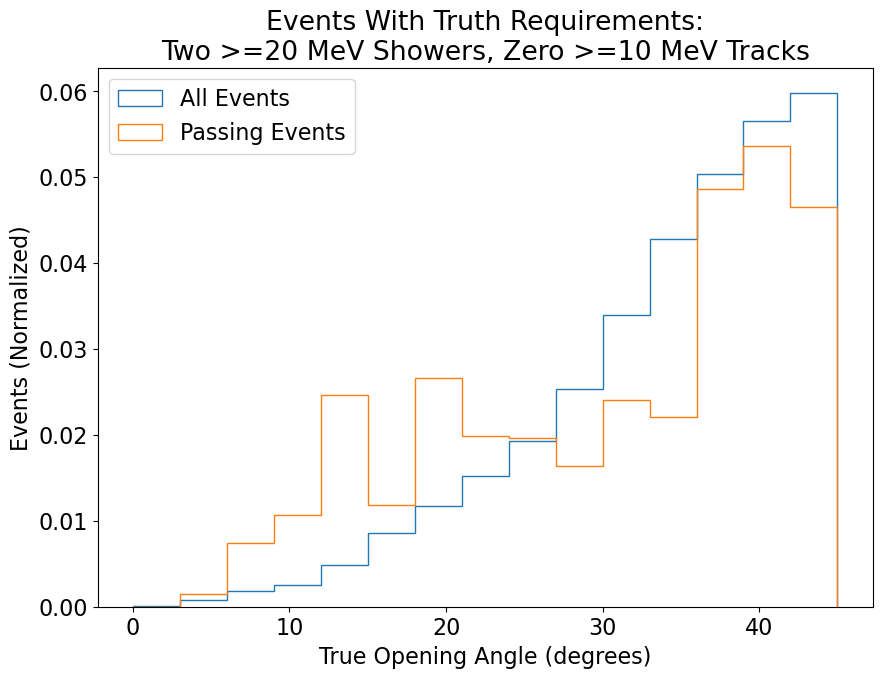

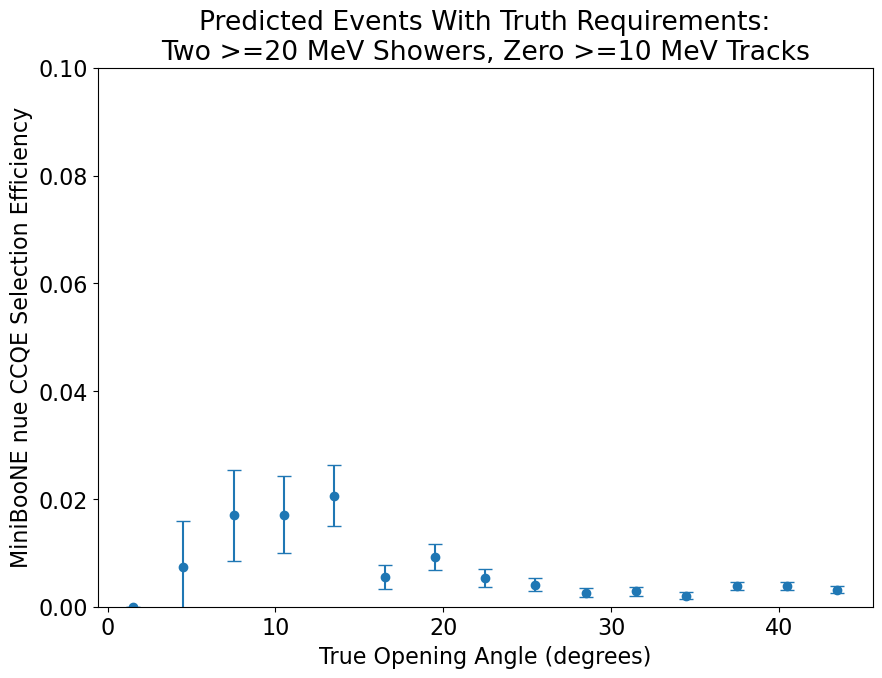

In [11]:
plt.rcParams.update({'font.size': 16})

#opening_angle_bins = np.linspace(0, 180, 18+1)
#opening_angle_bins = np.linspace(0, 90, 18+1)
opening_angle_bins = np.linspace(0, 45, 16)
opening_angle_bin_centers = [(opening_angle_bins[i] + opening_angle_bins[i+1]) / 2 for i in range(len(opening_angle_bins) - 1)]

total_counts = np.histogram(two_HE_shower_0_HE_track_df["opening_angle"], weights=two_HE_shower_0_HE_track_df["Weight"], bins=opening_angle_bins)[0]
passing_counts = np.histogram(passing_two_HE_shower_0_HE_track_df["opening_angle"], weights=passing_two_HE_shower_0_HE_track_df["Weight"], bins=opening_angle_bins)[0]
effs = passing_counts / total_counts

eff_errs = np.sqrt(effs * (1 - effs) / total_counts)

plt.figure(figsize=(10, 7))
plt.hist(two_HE_shower_0_HE_track_df["opening_angle"], weights=two_HE_shower_0_HE_track_df["Weight"], bins=opening_angle_bins, histtype="step", label="All Events")
plt.hist(passing_two_HE_shower_0_HE_track_df["opening_angle"], weights=passing_two_HE_shower_0_HE_track_df["Weight"], bins=opening_angle_bins, histtype="step", label="Passing Events")
plt.xlabel("True Opening Angle (degrees)")
plt.ylabel("Events")
plt.title(f"Events With Truth Requirements:\nTwo >={shower_threshold} MeV Showers, Zero >={track_threshold} MeV Tracks")
plt.legend()
plt.yscale("log")
plt.show()

plt.figure(figsize=(10, 7))
plt.hist(two_HE_shower_0_HE_track_df["opening_angle"], weights=two_HE_shower_0_HE_track_df["Weight"], bins=opening_angle_bins, histtype="step", density=True, label="All Events")
plt.hist(passing_two_HE_shower_0_HE_track_df["opening_angle"], weights=passing_two_HE_shower_0_HE_track_df["Weight"], bins=opening_angle_bins, histtype="step", density=True, label="Passing Events")
plt.xlabel("True Opening Angle (degrees)")
plt.ylabel("Events (Normalized)")
plt.title(f"Events With Truth Requirements:\nTwo >={shower_threshold} MeV Showers, Zero >={track_threshold} MeV Tracks")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.errorbar(opening_angle_bin_centers, effs, yerr=eff_errs, fmt="o", capsize=5)
plt.xlabel("True Opening Angle (degrees)")
plt.ylabel("MiniBooNE nue CCQE Selection Efficiency")
plt.title(f"Predicted Events With Truth Requirements:\nTwo >={shower_threshold} MeV Showers, Zero >={track_threshold} MeV Tracks")
plt.ylim(0, 0.1)
plt.show()

